100%|██████████| 53/53 [00:00<00:00, 214.75it/s]


629
target_data_pct
1.00    119
0.01    102
0.10    102
0.05    102
0.50    102
0.25    102
Name: count, dtype: int64
fold
5     37
11    37
15    37
10    37
9     37
2     37
13    37
3     37
12    37
4     37
6     37
7     37
0     37
14    37
8     37
16    37
1     37
Name: count, dtype: int64


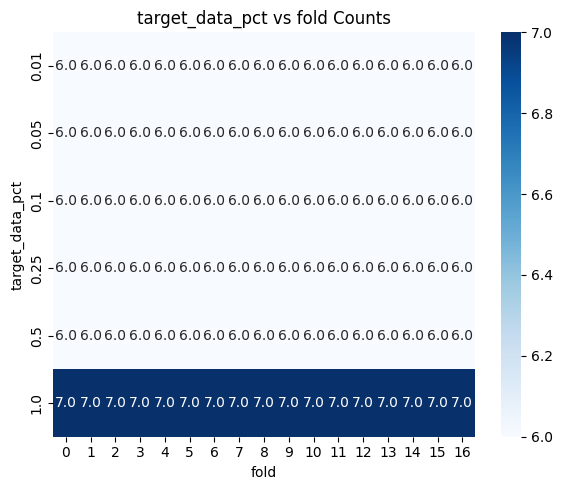

In [3]:
"""
This block plots performance from entire experiments directory for something like a hyperparameter sweep.
"""
import os
import json
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from lib.models import TestModel
from lib.train_utils import compute_loss_and_f1, plot_hyperparameter_counts, load_experiments_from_dir

experiments_dir = f'./experiments'

df = load_experiments_from_dir(experiments_dir, device='cuda')

def get_base_test_f1(row):
    if row['mode'] == 'base':
        return row['test_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['test_f1'].iloc[0] if len(base_row) > 0 else None

def get_base_val_f1(row):
    if row['mode'] == 'base':
        return row['target_val_f1']
    else:
        base_row = df[df['experiment'] == row['base_experiment_prefix']]
        return base_row['target_val_f1'].iloc[0] if len(base_row) > 0 else None
    
df['base_test_f1'] = df.apply(get_base_test_f1, axis=1)
df['base_target_val_f1'] = df.apply(get_base_val_f1, axis=1)

df['absolute_improvement'] = df['test_f1'] - df['base_test_f1']
df['relative_improvement'] = df['absolute_improvement'] / df['base_test_f1']
df['room_for_improvement'] = 1.0 - df['base_test_f1']
df['relative_to_room_for_improvement'] = df['absolute_improvement'] / df['room_for_improvement']

df['absolute_improvement_val'] = df['best_val_f1'] - df['base_target_val_f1']
df['relative_improvement_val'] = df['absolute_improvement_val'] / df['base_target_val_f1']
df['room_for_improvement_val'] = 1.0 - df['base_target_val_f1']
df['relative_to_room_for_improvement_val'] = df['absolute_improvement_val'] / df['room_for_improvement_val']

df['base_test_precision'] = df.apply(lambda row: row['test_precision'] if row['mode'] == 'base' else df[df['experiment'] == row['base_experiment_prefix']]['test_precision'].iloc[0] if len(df[df['experiment'] == row['base_experiment_prefix']]) > 0 else None, axis=1)
df['base_test_recall'] = df.apply(lambda row: row['test_recall'] if row['mode'] == 'base' else df[df['experiment'] == row['base_experiment_prefix']]['test_recall'].iloc[0] if len(df[df['experiment'] == row['base_experiment_prefix']]) > 0 else None, axis=1)
df['precision_improvement'] = df['test_precision'] - df['base_test_precision']
df['recall_improvement'] = df['test_recall'] - df['base_test_recall']

print(len(df))
hyperparameters_to_plot = ['target_data_pct','fold']
for hp in hyperparameters_to_plot:
    print(df[hp].value_counts())
plot_hyperparameter_counts(df, hyperparameters_to_plot)

<Axes: ylabel='test_f1'>

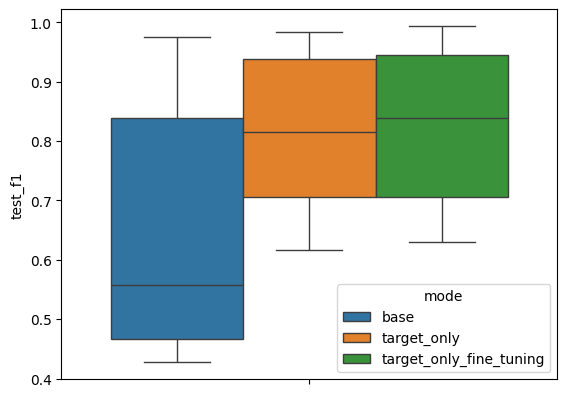

In [4]:
df_plot = df.copy()
df_plot = df_plot[df_plot['base_channels'] == 64]
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
sns.boxplot(data=df_plot, y='test_f1',hue='mode')

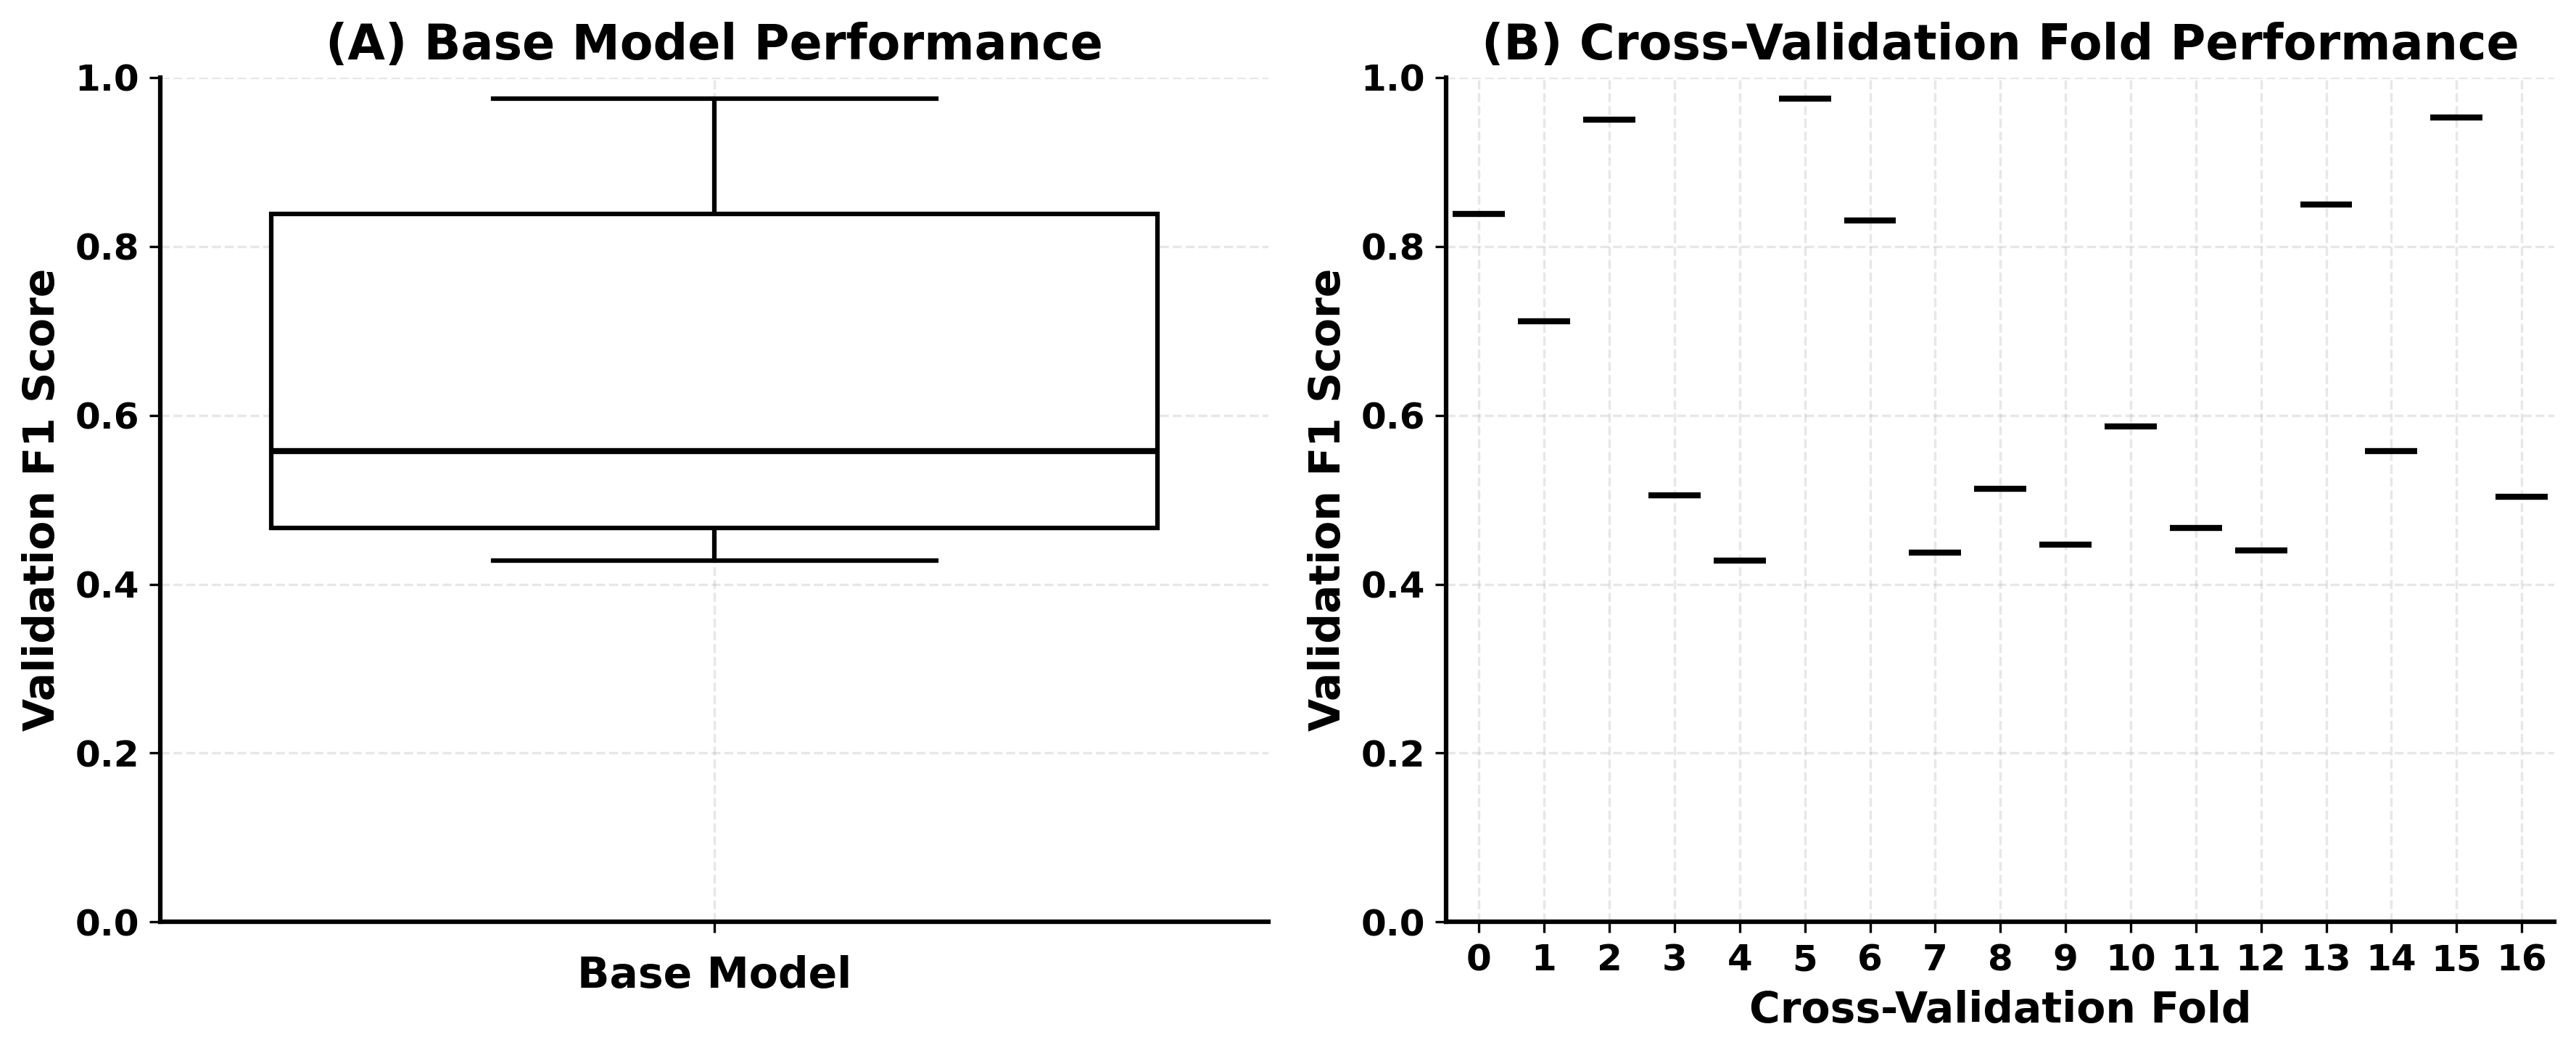

In [5]:
# Set publication-ready style
plt.rcParams.update({
    'font.size': 12,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'figure.dpi': 300,
    'axes.linewidth': 1.5,
    'axes.spines.top': False,
    'axes.spines.right': False
})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=300)

# Create black and white boxplots
sns.boxplot(data=df[df['mode'] == 'base'], y='test_f1', ax=ax[0], 
           color='white', linewidth=1.5, 
           boxprops=dict(edgecolor='black', linewidth=1.5),
           whiskerprops=dict(color='black', linewidth=1.5),
           capprops=dict(color='black', linewidth=1.5),
           medianprops=dict(color='black', linewidth=2),
           flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=4))

sns.boxplot(data=df[df['mode'] == 'base'], x='fold', y='test_f1', ax=ax[1],
           color='white', linewidth=1.5,
           boxprops=dict(edgecolor='black', linewidth=1.5),
           whiskerprops=dict(color='black', linewidth=1.5),
           capprops=dict(color='black', linewidth=1.5),
           medianprops=dict(color='black', linewidth=2),
           flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=4))

# Set limits and labels
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].set_title('(A) Base Model Performance', fontsize=16, fontweight='bold')
ax[1].set_title('(B) Cross-Validation Fold Performance', fontsize=16, fontweight='bold')
# Bold and properly formatted labels
ax[0].set_ylabel('Validation F1 Score', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Base Model', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Validation F1 Score', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Cross-Validation Fold', fontsize=14, fontweight='bold')

# Add grid for better readability
for axis in ax:
    axis.grid(True, alpha=0.3, linestyle='--')
    axis.set_axisbelow(True)
    
# Adjust layout for publication
plt.tight_layout()

# Save as high-quality figure for publication
plt.savefig('figure1.pdf', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.savefig('figure1.png', dpi=300, bbox_inches='tight',
           facecolor='white', edgecolor='none')
plt.show()

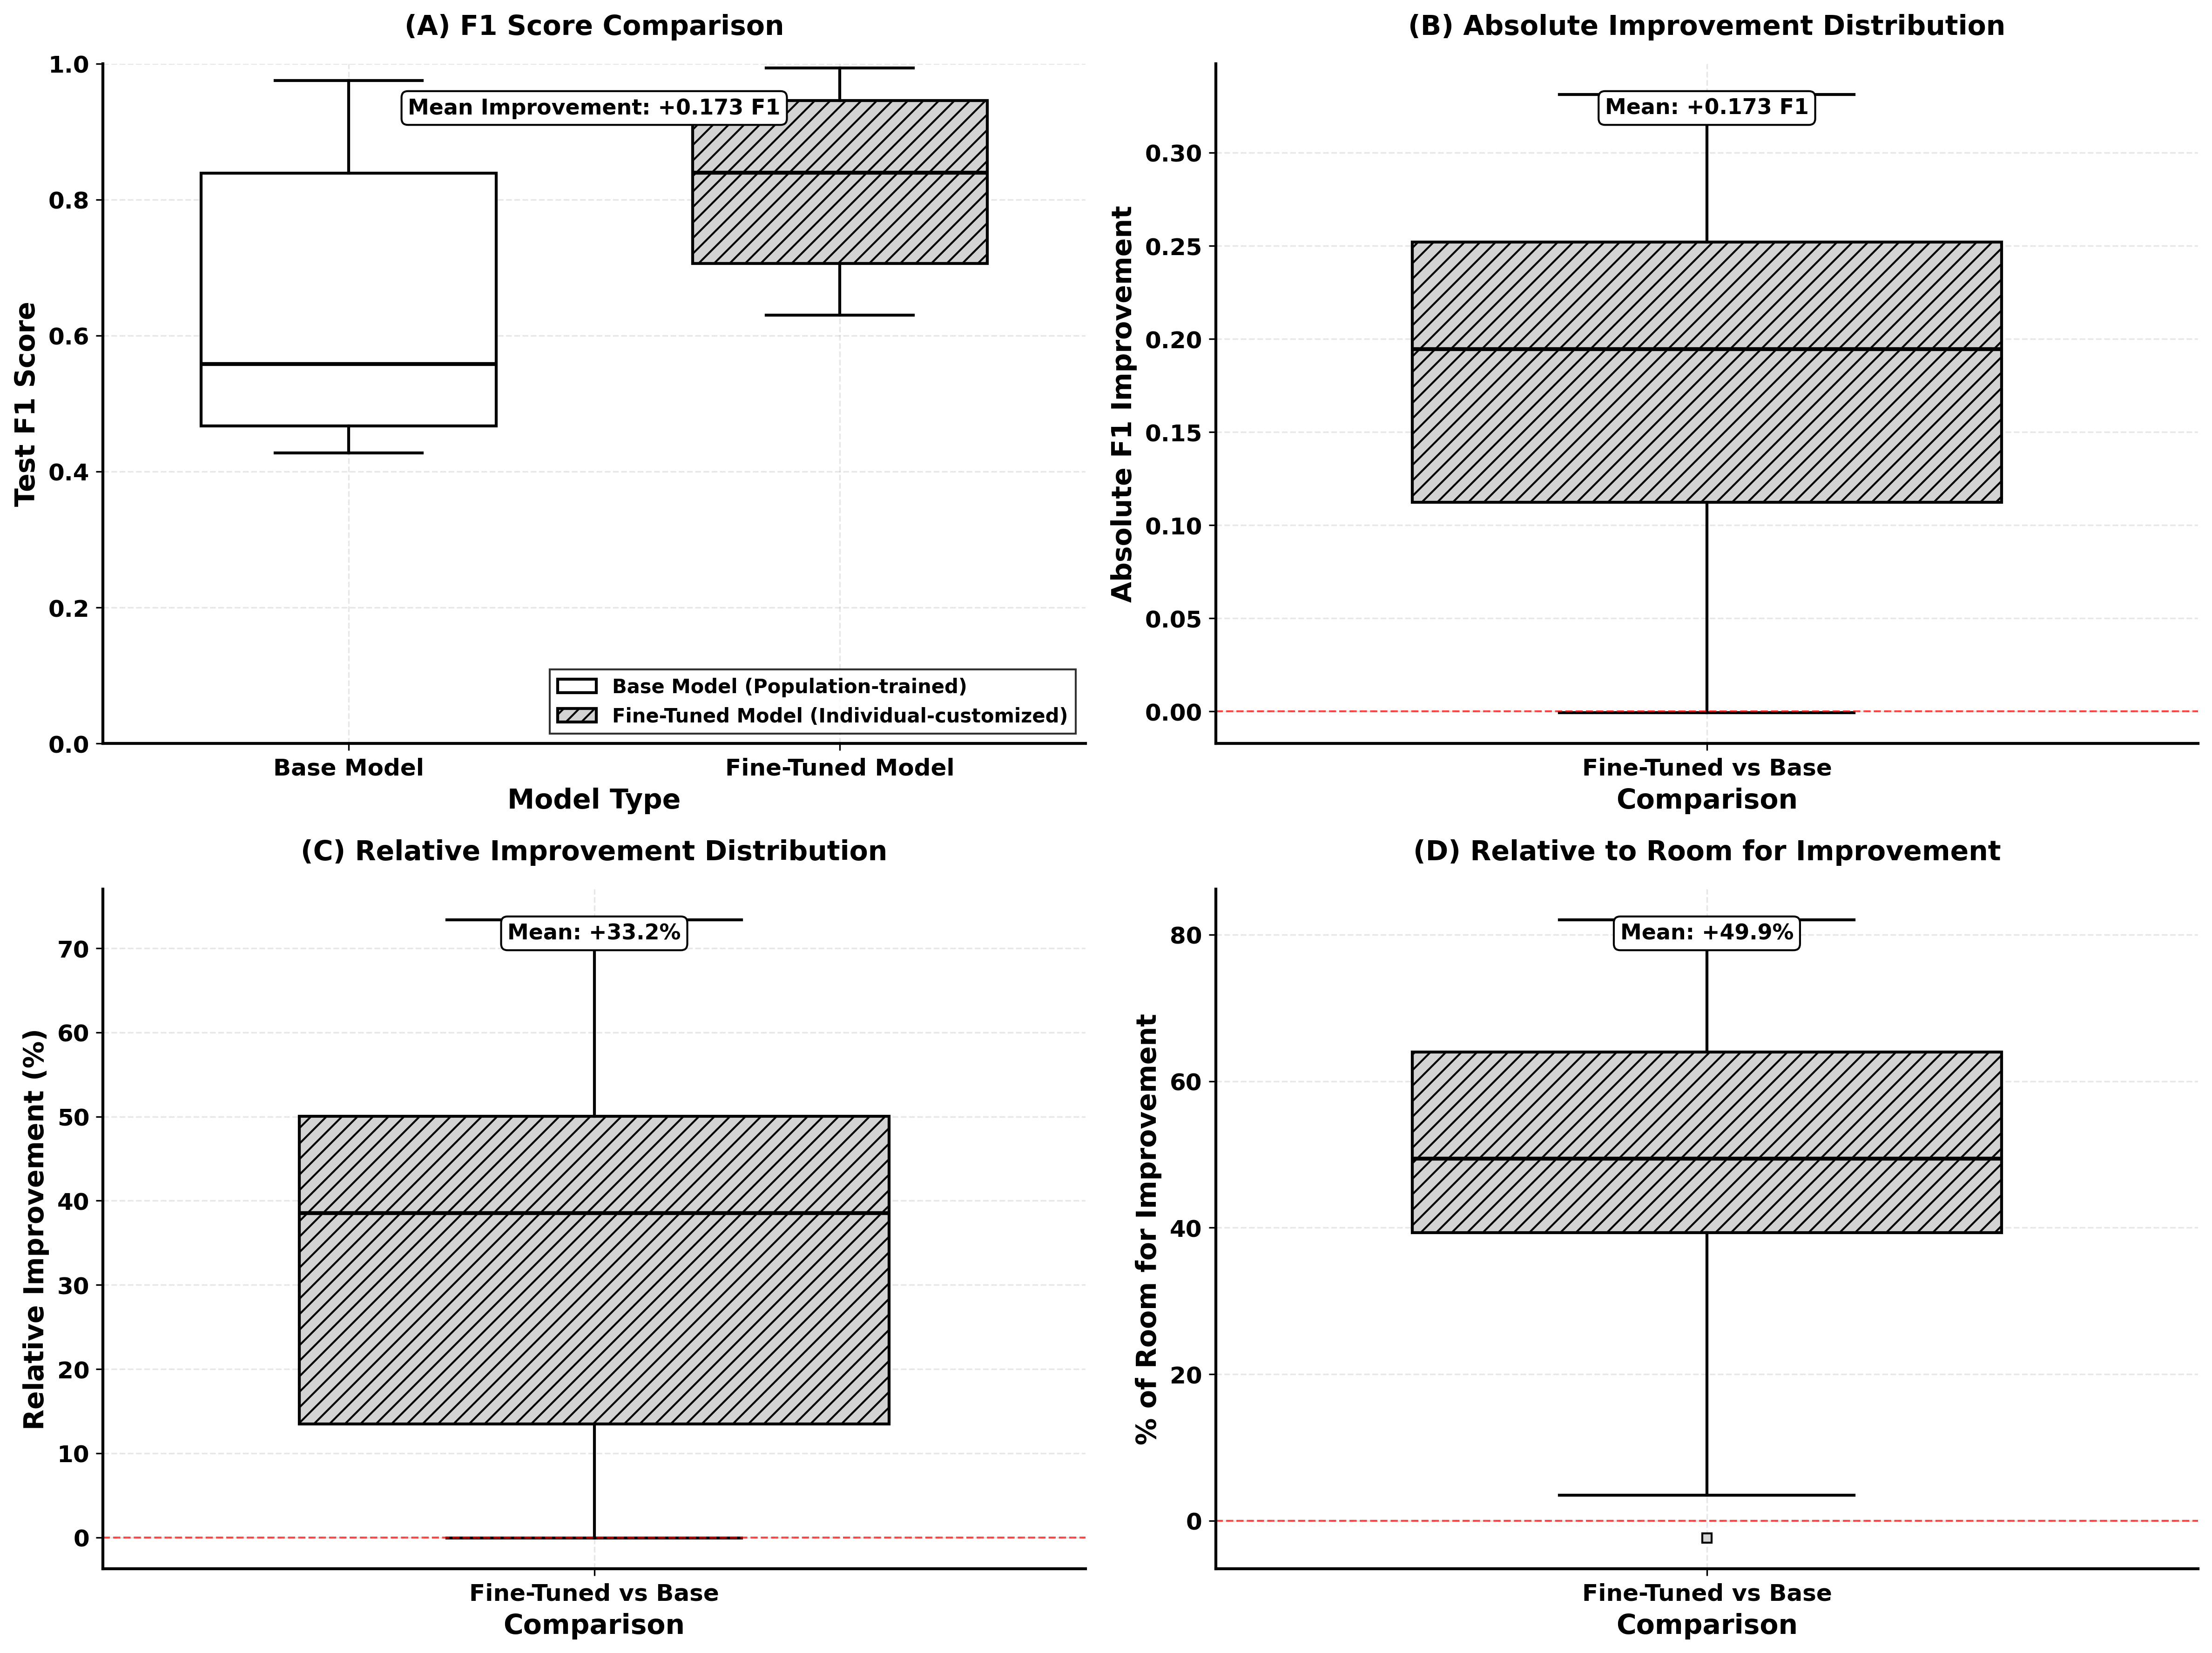

In [6]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
df_plot = df_plot[df_plot['base_channels'] == 64]

# Clean up mode names for publication
df_plot['mode_clean'] = df_plot['mode'].map({
    'base': 'Base Model',
    'target_only_fine_tuning': 'Fine-Tuned Model'
})

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), dpi=300)
ax = axes.flatten()

# Define distinct black and white styles for each method
base_props = {
    'boxprops': dict(facecolor='white', edgecolor='black', linewidth=1.5),
    'whiskerprops': dict(color='black', linewidth=1.5),
    'capprops': dict(color='black', linewidth=1.5),
    'medianprops': dict(color='black', linewidth=2),
    'flierprops': dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5)
}

finetuned_props = {
    'boxprops': dict(facecolor='lightgray', edgecolor='black', linewidth=1.5, hatch='///'),
    'whiskerprops': dict(color='black', linewidth=1.5),
    'capprops': dict(color='black', linewidth=1.5),
    'medianprops': dict(color='black', linewidth=2),
    'flierprops': dict(marker='s', markerfacecolor='lightgray', markeredgecolor='black', markersize=5)
}

# Plot 1: F1 Score Comparison (top-left)
base_data = df_plot[df_plot['mode'] == 'base']['test_f1']
finetuned_data = df_plot[df_plot['mode'] == 'target_only_fine_tuning']['test_f1']

positions = [1, 2]
width = 0.6

# Plot base model
box1 = ax[0].boxplot([base_data], positions=[positions[0]], widths=width, 
                     patch_artist=True, **base_props)

# Plot fine-tuned model  
box2 = ax[0].boxplot([finetuned_data], positions=[positions[1]], widths=width,
                     patch_artist=True, **finetuned_props)

# Customize F1 plot
ax[0].set_xticks(positions)
ax[0].set_xticklabels(['Base Model', 'Fine-Tuned Model'], fontsize=12, fontweight='bold')
ax[0].set_ylabel('Test F1 Score', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Model Type', fontsize=14, fontweight='bold')
ax[0].set_ylim(0, 1)
ax[0].set_title('(A) F1 Score Comparison', fontsize=14, fontweight='bold', pad=15)

# Calculate improvement for annotation
base_mean = base_data.mean()
finetuned_mean = finetuned_data.mean()
improvement = finetuned_mean - base_mean

# Add improvement text
ax[0].text(0.5, 0.95, f'Mean Improvement: +{improvement:.3f} F1', 
           transform=ax[0].transAxes, fontsize=11, fontweight='bold',
           ha='center', va='top', bbox=dict(boxstyle='round,pad=0.3', 
                                          facecolor='white', edgecolor='black'))

# Plot 2: Absolute Improvement Distribution (top-right)
finetune_only_data = df_plot[df_plot['mode'] == 'target_only_fine_tuning']
abs_improvement_data = finetune_only_data['absolute_improvement']

box3 = ax[1].boxplot([abs_improvement_data], positions=[1], widths=0.6,
                     patch_artist=True, **finetuned_props)

ax[1].set_xticks([1])
ax[1].set_xticklabels(['Fine-Tuned vs Base'], fontsize=12, fontweight='bold')
ax[1].set_ylabel('Absolute F1 Improvement', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Comparison', fontsize=14, fontweight='bold')
ax[1].set_title('(B) Absolute Improvement Distribution', fontsize=14, fontweight='bold', pad=15)
ax[1].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)

# Add mean annotation
abs_mean = abs_improvement_data.mean()
ax[1].text(0.5, 0.95, f'Mean: +{abs_mean:.3f} F1', 
           transform=ax[1].transAxes, fontsize=11, fontweight='bold',
           ha='center', va='top', bbox=dict(boxstyle='round,pad=0.3', 
                                          facecolor='white', edgecolor='black'))

# Plot 3: Relative Improvement Distribution (bottom-left)
rel_improvement_data = finetune_only_data['relative_improvement'] * 100

box4 = ax[2].boxplot([rel_improvement_data], positions=[1], widths=0.6,
                     patch_artist=True, **finetuned_props)

ax[2].set_xticks([1])
ax[2].set_xticklabels(['Fine-Tuned vs Base'], fontsize=12, fontweight='bold')
ax[2].set_ylabel('Relative Improvement (%)', fontsize=14, fontweight='bold')
ax[2].set_xlabel('Comparison', fontsize=14, fontweight='bold')
ax[2].set_title('(C) Relative Improvement Distribution', fontsize=14, fontweight='bold', pad=15)
ax[2].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)

# Add mean annotation
rel_mean = rel_improvement_data.mean()
ax[2].text(0.5, 0.95, f'Mean: +{rel_mean:.1f}%', 
           transform=ax[2].transAxes, fontsize=11, fontweight='bold',
           ha='center', va='top', bbox=dict(boxstyle='round,pad=0.3', 
                                          facecolor='white', edgecolor='black'))

# Plot 4: Room for Improvement Distribution (bottom-right)
room_improvement_data = finetune_only_data['relative_to_room_for_improvement'] * 100

box5 = ax[3].boxplot([room_improvement_data], positions=[1], widths=0.6,
                     patch_artist=True, **finetuned_props)

ax[3].set_xticks([1])
ax[3].set_xticklabels(['Fine-Tuned vs Base'], fontsize=12, fontweight='bold')
ax[3].set_ylabel('% of Room for Improvement', fontsize=14, fontweight='bold')
ax[3].set_xlabel('Comparison', fontsize=14, fontweight='bold')
ax[3].set_title('(D) Relative to Room for Improvement', fontsize=14, fontweight='bold', pad=15)
ax[3].axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=1)

# Add mean annotation
room_mean = room_improvement_data.mean()
ax[3].text(0.5, 0.95, f'Mean: +{room_mean:.1f}%', 
           transform=ax[3].transAxes, fontsize=11, fontweight='bold',
           ha='center', va='top', bbox=dict(boxstyle='round,pad=0.3', 
                                          facecolor='white', edgecolor='black'))

# Add grid for better readability to all plots
for i in range(4):
    ax[i].grid(True, alpha=0.3, linestyle='--')
    ax[i].set_axisbelow(True)

# Create comprehensive legend (only for the first plot)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='white', edgecolor='black', linewidth=1.5, label='Base Model (Population-trained)'),
    Patch(facecolor='lightgray', edgecolor='black', linewidth=1.5, hatch='///', label='Fine-Tuned Model (Individual-customized)')
]

ax[0].legend(handles=legend_elements, loc='lower right', fontsize=10, frameon=True, 
             fancybox=False, edgecolor='black')

# Adjust layout for publication
plt.tight_layout()

# Save as high-quality figure for publication
plt.savefig('figure2.pdf', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.savefig('figure2.png', dpi=300, bbox_inches='tight',
           facecolor='white', edgecolor='none')

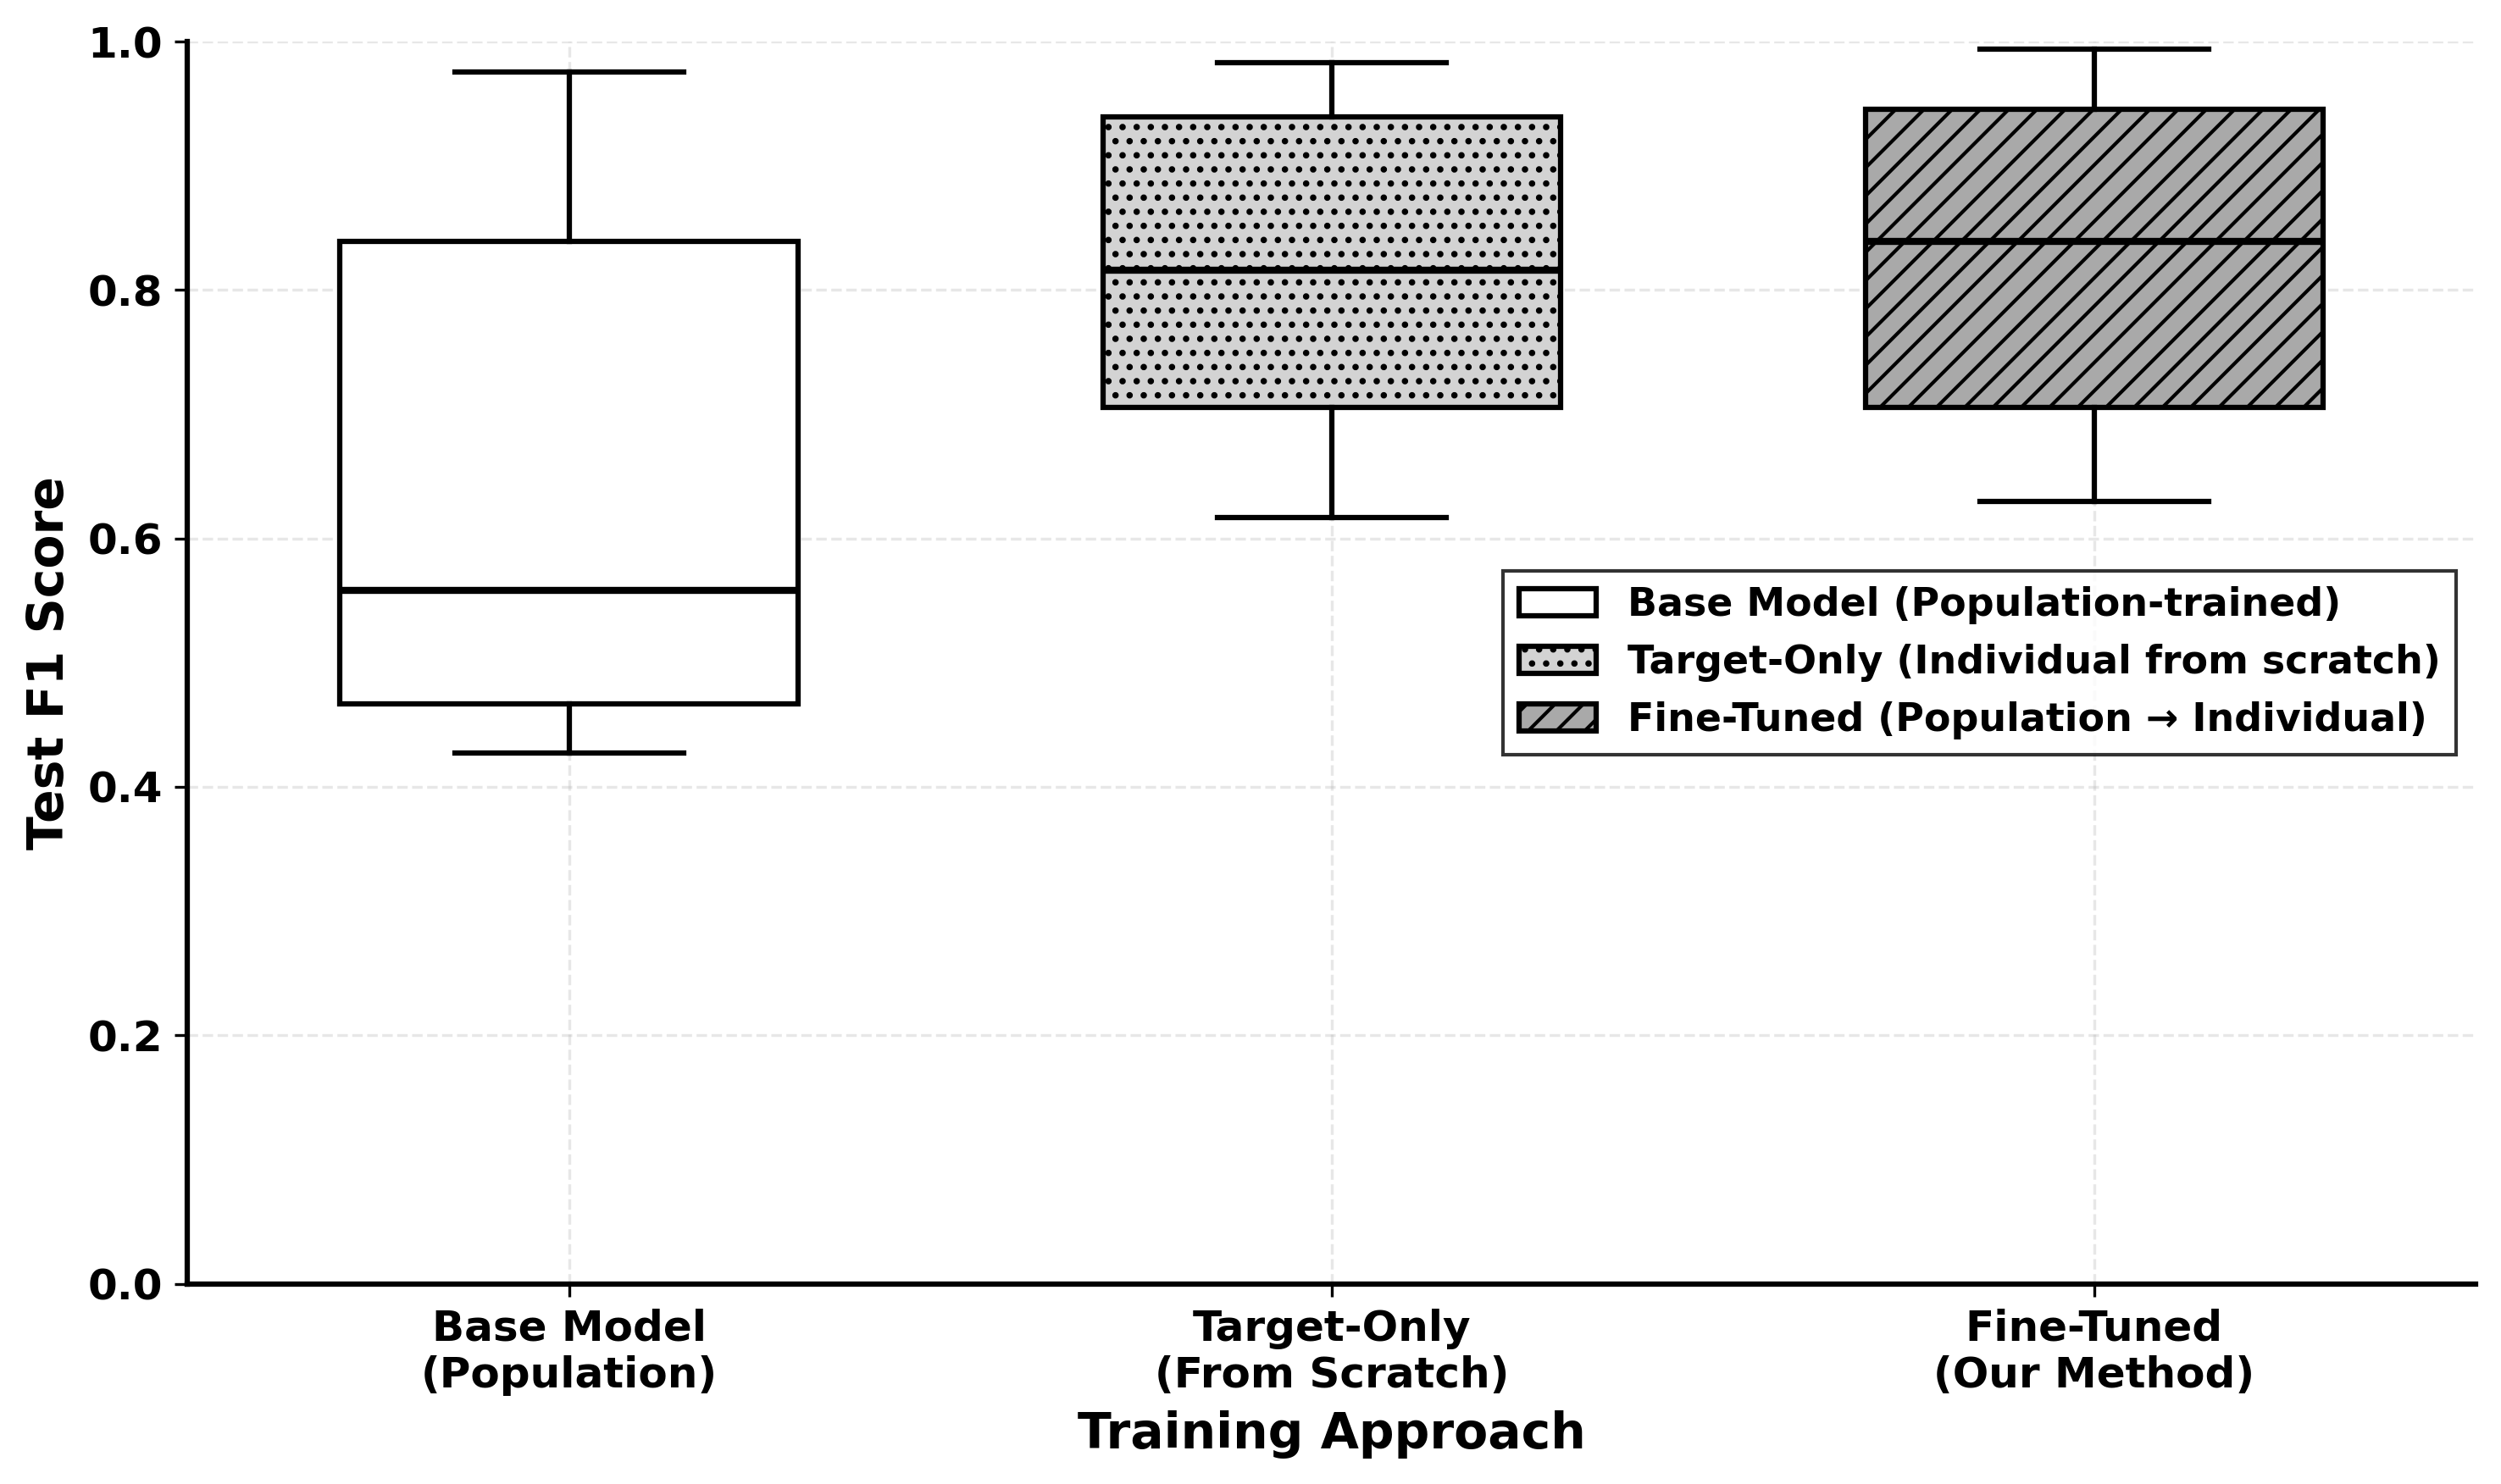

In [7]:
df_plot = df.copy()
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
df_plot = df_plot[df_plot['base_channels'] == 64]

# Clean up mode names for publication
df_plot['mode_clean'] = df_plot['mode'].map({
    'base': 'Base Model\n(Population)',
    'target_only': 'Target-Only\n(From Scratch)',
    'target_only_fine_tuning': 'Fine-Tuned\n(Our Method)'
})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), dpi=300)

# Define distinct black and white styles for each method
base_props = {
    'boxprops': dict(facecolor='white', edgecolor='black', linewidth=1.5),
    'whiskerprops': dict(color='black', linewidth=1.5),
    'capprops': dict(color='black', linewidth=1.5),
    'medianprops': dict(color='black', linewidth=2),
    'flierprops': dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=5)
}

target_only_props = {
    'boxprops': dict(facecolor='lightgray', edgecolor='black', linewidth=1.5, hatch='...'),
    'whiskerprops': dict(color='black', linewidth=1.5),
    'capprops': dict(color='black', linewidth=1.5),
    'medianprops': dict(color='black', linewidth=2),
    'flierprops': dict(marker='^', markerfacecolor='lightgray', markeredgecolor='black', markersize=5)
}

finetuned_props = {
    'boxprops': dict(facecolor='darkgray', edgecolor='black', linewidth=1.5, hatch='///'),
    'whiskerprops': dict(color='black', linewidth=1.5),
    'capprops': dict(color='black', linewidth=1.5),
    'medianprops': dict(color='black', linewidth=2),
    'flierprops': dict(marker='s', markerfacecolor='darkgray', markeredgecolor='black', markersize=5)
}

# Extract data for each method
base_data = df_plot[df_plot['mode'] == 'base']['test_f1']
target_only_data = df_plot[df_plot['mode'] == 'target_only']['test_f1']
finetuned_data = df_plot[df_plot['mode'] == 'target_only_fine_tuning']['test_f1']

positions = [1, 2, 3]
width = 0.6

# Plot all three methods
box1 = ax.boxplot([base_data], positions=[positions[0]], widths=width, 
                  patch_artist=True, **base_props)
box2 = ax.boxplot([target_only_data], positions=[positions[1]], widths=width,
                  patch_artist=True, **target_only_props)
box3 = ax.boxplot([finetuned_data], positions=[positions[2]], widths=width,
                  patch_artist=True, **finetuned_props)

# Customize plot
ax.set_xticks(positions)
ax.set_xticklabels(['Base Model\n(Population)', 'Target-Only\n(From Scratch)', 'Fine-Tuned\n(Our Method)'], 
                   fontsize=12, fontweight='bold')
ax.set_ylabel('Test F1 Score', fontsize=14, fontweight='bold')
ax.set_xlabel('Training Approach', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Calculate means and improvements
base_mean = base_data.mean()
target_only_mean = target_only_data.mean()
finetuned_mean = finetuned_data.mean()

improvement_vs_base = finetuned_mean - base_mean
improvement_vs_target_only = finetuned_mean - target_only_mean

# Create comprehensive legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='white', edgecolor='black', linewidth=1.5, 
          label='Base Model (Population-trained)'),
    Patch(facecolor='lightgray', edgecolor='black', linewidth=1.5, hatch='...', 
          label='Target-Only (Individual from scratch)'),
    Patch(facecolor='darkgray', edgecolor='black', linewidth=1.5, hatch='///', 
          label='Fine-Tuned (Population → Individual)')
]

ax.legend(handles=legend_elements, loc='center right', fontsize=11, frameon=True, 
          fancybox=False, edgecolor='black')

# Adjust layout for publication
plt.tight_layout()

# Save as high-quality figure for publication
plt.savefig('figure3.pdf', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.savefig('figure3.png', dpi=300, bbox_inches='tight',
           facecolor='white', edgecolor='none')

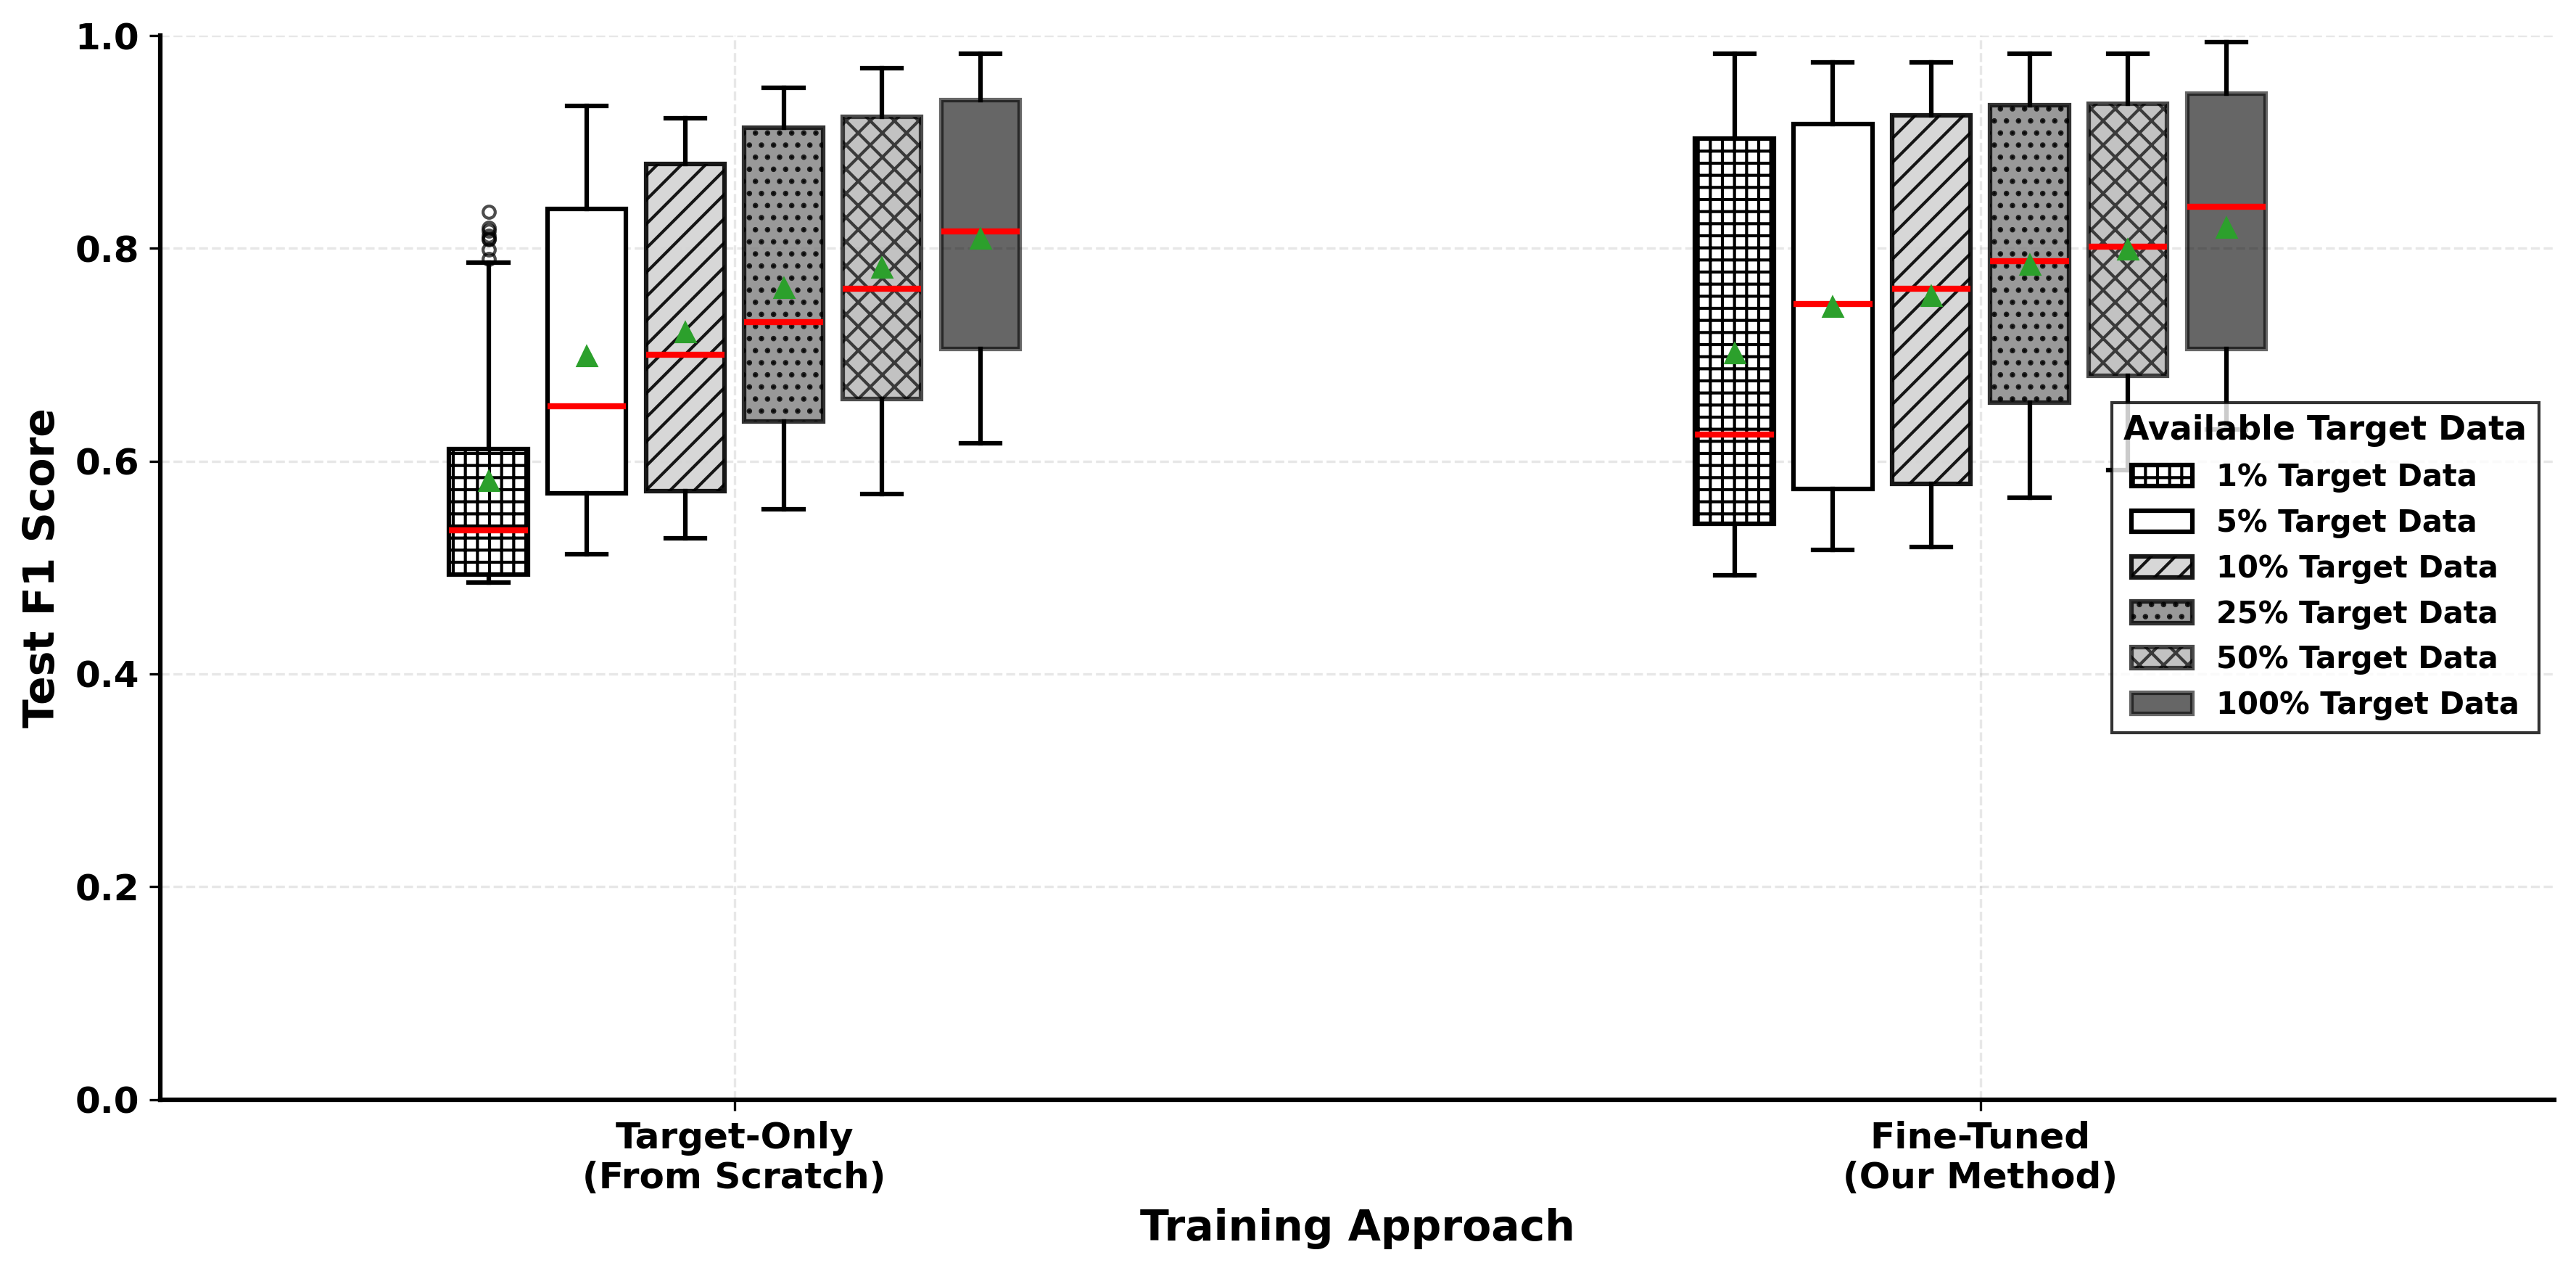

In [8]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'base']
df_plot = df_plot[df_plot['base_channels'] == 64]

# Clean up mode names for publication
df_plot['mode_clean'] = df_plot['mode'].map({
    'target_only': 'Target-Only\n(From Scratch)',
    'target_only_fine_tuning': 'Fine-Tuned\n(Our Method)'
})

# Convert target_data_pct to percentage for better readability
df_plot['target_data_pct_label'] = (df_plot['target_data_pct'] * 100).astype(int).astype(str) + '%'

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), dpi=300)

# Define distinct black and white patterns for different data percentages
data_pct_patterns = {
    '1%': {'facecolor': 'white', 'hatch': '+++', 'edgecolor': 'black', 'alpha': 1.0},
    '5%': {'facecolor': 'white', 'hatch': None, 'edgecolor': 'black', 'alpha': 1.0},
    '10%': {'facecolor': 'lightgray', 'hatch': '///', 'edgecolor': 'black', 'alpha': 0.9},
    '25%': {'facecolor': 'gray', 'hatch': '...', 'edgecolor': 'black', 'alpha': 0.8},
    '50%': {'facecolor': 'darkgray', 'hatch': 'xxx', 'edgecolor': 'black', 'alpha': 0.7},
    '100%': {'facecolor': 'black', 'hatch': None, 'edgecolor': 'black', 'alpha': 0.6}
}

# Define the order for data percentages and training approaches
data_pct_order = ['1%', '5%', '10%', '25%', '50%', '100%']
mode_order = ['Target-Only\n(From Scratch)', 'Fine-Tuned\n(Our Method)']

# Manually create boxplots to ensure proper ordering and consistent patterns
positions = []
box_data = []
colors = []
hatches = []
alphas = []

# Calculate positions for each box
mode_spacing = 1.0  # Space between training approaches
pct_spacing = 0.15  # Space between data percentages within each approach

for mode_idx, mode in enumerate(mode_order):
    for pct_idx, pct in enumerate(data_pct_order):
        # Get data for this combination
        data_subset = df_plot[(df_plot['mode_clean'] == mode) & 
                             (df_plot['target_data_pct_label'] == pct)]['test_f1']
        
        if len(data_subset) > 0:
            # Calculate position
            base_pos = mode_idx * (mode_spacing + len(data_pct_order) * pct_spacing)
            pos = base_pos + pct_idx * pct_spacing
            
            positions.append(pos)
            box_data.append(data_subset.values)
            
            # Apply consistent patterns
            pattern_info = data_pct_patterns[pct]
            colors.append(pattern_info['facecolor'])
            hatches.append(pattern_info['hatch'])
            alphas.append(pattern_info['alpha'])

# Create the boxplot
box_plot = ax.boxplot(box_data, positions=positions, widths=0.12, 
                     patch_artist=True, showfliers=True,
                     boxprops=dict(linewidth=1.5),
                     medianprops=dict(linewidth=2, color='red'),
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5),
                     flierprops=dict(marker='o', markersize=4, alpha=0.7),showmeans=True)

# Apply colors and patterns to each box
for patch, color, hatch, alpha in zip(box_plot['boxes'], colors, hatches, alphas):
    patch.set_facecolor(color)
    patch.set_hatch(hatch)
    patch.set_alpha(alpha)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.5)

# Set x-axis labels and positions
mode_positions = []
for mode_idx, mode in enumerate(mode_order):
    # Calculate center position for each mode
    base_pos = mode_idx * (mode_spacing + len(data_pct_order) * pct_spacing)
    center_pos = base_pos + (len(data_pct_order) - 1) * pct_spacing / 2
    mode_positions.append(center_pos)

ax.set_xticks(mode_positions)
ax.set_xticklabels(mode_order, fontsize=12, fontweight='bold')

# Customize plot appearance
ax.set_ylabel('Test F1 Score', fontsize=14, fontweight='bold')
ax.set_xlabel('Training Approach', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)

# Create custom legend for data percentages
from matplotlib.patches import Patch
legend_elements = []
for pct in data_pct_order:
    pattern_info = data_pct_patterns[pct]
    legend_elements.append(
        Patch(facecolor=pattern_info['facecolor'], 
              edgecolor='black', 
              linewidth=1.5,
              hatch=pattern_info['hatch'],
              alpha=pattern_info['alpha'],
              label=f'{pct} Target Data')
    )

# Position legend to not interfere with data
ax.legend(handles=legend_elements, loc='center right', fontsize=10, 
          frameon=True, fancybox=False, edgecolor='black',
          title='Available Target Data', title_fontsize=11)

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Adjust layout for publication
plt.tight_layout()

# Save as high-quality figure for publication
plt.savefig('figure4.pdf', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.savefig('figure4.png', dpi=300, bbox_inches='tight',
           facecolor='white', edgecolor='none')

In [9]:
import pandas as pd
from scipy import stats

# Assuming df is your original DataFrame (replace with your actual df)
df_plot = df.copy()

df_plot = df_plot[df_plot['target_data_pct'] == 1.0]

# Filter out 'base' mode
df_plot = df_plot[df_plot['mode'] != 'base']

# Pivot the data to get paired test_f1 scores
df_pivot = df_plot.pivot_table(index=['fold', 'seed_finetune'], columns='mode', values='test_f1')

# Extract paired F1 scores
f1_target_only = df_pivot['target_only']
f1_fine_tuning = df_pivot['target_only_fine_tuning']

# Compute differences
differences = f1_fine_tuning - f1_target_only
mean_diff = differences.mean()
print(f"Mean difference in test F1: {mean_diff:.4f}")

# Check normality of differences (Shapiro-Wilk test)
from scipy.stats import shapiro
shapiro_stat, shapiro_p = shapiro(differences.dropna())
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f} (if >0.05, assume normal)")

# Choose and run the paired test
if shapiro_p > 0.05 and len(differences) >= 3:  # Minimum for t-test
    t_stat, p_value = stats.ttest_rel(f1_fine_tuning.dropna(), f1_target_only.dropna(), alternative='greater')
    test_name = "Paired t-test"
else:
    stat, p_value = stats.wilcoxon(f1_fine_tuning.dropna() - f1_target_only.dropna(), alternative='greater')
    test_name = "Wilcoxon signed-rank test"

print(f"{test_name} p-value: {p_value:.8f}")

# Interpret
alpha = 0.05
if p_value < alpha:
    print("target_only_fine_tuning is significantly better than target_only.")
else:
    print("No significant difference detected.")

Mean difference in test F1: 0.0106
Shapiro-Wilk p-value: 0.4736 (if >0.05, assume normal)
Paired t-test p-value: 0.00004650
target_only_fine_tuning is significantly better than target_only.


In [10]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
df_plot = df_plot[df_plot['base_channels'] == 64]

df_grouped = df_plot.groupby('fold')[['base_test_f1','test_f1','absolute_improvement','relative_improvement','relative_to_room_for_improvement','test_precision','test_recall','precision_improvement','recall_improvement']].mean()

n_participants = df['fold'].nunique()
base_test_f1_mean = df_grouped['base_test_f1'].mean()
base_test_f1_std = df_grouped['base_test_f1'].std()
base_test_f1_min = df_grouped['base_test_f1'].min()
base_test_f1_max = df_grouped['base_test_f1'].max()
finetune_test_f1_mean = df_grouped['test_f1'].mean()
finetune_test_f1_std = df_grouped['test_f1'].std()
finetune_test_f1_min = df_grouped['test_f1'].min()
finetune_test_f1_max = df_grouped['test_f1'].max()
absolute_improvement_mean = df_grouped['absolute_improvement'].mean()
absolute_improvement_std = df_grouped['absolute_improvement'].std()
absolute_improvement_min = df_grouped['absolute_improvement'].min()
absolute_improvement_max = df_grouped['absolute_improvement'].max()
relative_improvement_mean = df_grouped['relative_improvement'].mean()*100
relative_improvement_std = df_grouped['relative_improvement'].std()*100
relative_improvement_min = df_grouped['relative_improvement'].min()*100
relative_improvement_max = df_grouped['relative_improvement'].max()*100
relative_room_for_improvement_mean = df_grouped['relative_to_room_for_improvement'].mean()*100
relative_room_for_improvement_std = df_grouped['relative_to_room_for_improvement'].std()*100
relative_room_for_improvement_min = df_grouped['relative_to_room_for_improvement'].min()*100
relative_room_for_improvement_max = df_grouped['relative_to_room_for_improvement'].max()*100
precision_mean = df_grouped['test_precision'].mean()
precision_std = df_grouped['test_precision'].std()
precision_improvement_mean = df_grouped['precision_improvement'].mean()
recall_mean = df_grouped['test_recall'].mean()
recall_std = df_grouped['test_recall'].std()
recall_improvement_mean = df_grouped['recall_improvement'].mean()

# 1% data regime metrics
df_1pct_full = df.copy()
df_1pct_full = df_1pct_full[df_1pct_full['base_channels'] == 64]
df_1pct_full = df_1pct_full[df_1pct_full['target_data_pct'] == 0.01]

df_1pct_finetune = df_1pct_full[df_1pct_full['mode'] == 'target_only_fine_tuning']
df_1pct_target_only = df_1pct_full[df_1pct_full['mode'] == 'target_only']

df_1pct_finetune_grouped = df_1pct_finetune.groupby('fold')['test_f1'].mean()
df_1pct_target_only_grouped = df_1pct_target_only.groupby('fold')['test_f1'].mean()

one_pct_finetune_median = df_1pct_finetune_grouped.median()
one_pct_target_only_median = df_1pct_target_only_grouped.median()
one_pct_absolute_improvement = one_pct_finetune_median - one_pct_target_only_median

# Retention percentage for 1% fine-tuning
df_100pct_finetune = df[(df['base_channels'] == 64) & (df['target_data_pct'] == 1.0) & (df['mode'] == 'target_only_fine_tuning')]
df_100pct_finetune_grouped = df_100pct_finetune.groupby('fold')['test_f1'].mean()
one_pct_retention_pct = (one_pct_finetune_median / df_100pct_finetune_grouped.median()) * 100

latex_code = rf"""
\newcommand{{\nParticipants}}{{{n_participants}}}
\newcommand{{\baseFoneMean}}{{{base_test_f1_mean:.3f}}}
\newcommand{{\baseFoneStd}}{{{base_test_f1_std:.3f}}}
\newcommand{{\baseFoneMax}}{{{base_test_f1_max:.3f}}}
\newcommand{{\baseFoneMin}}{{{base_test_f1_min:.3f}}}
\newcommand{{\finetuneFoneMean}}{{{finetune_test_f1_mean:.3f}}}
\newcommand{{\finetuneFoneStd}}{{{finetune_test_f1_std:.3f}}}
\newcommand{{\finetuneFoneMax}}{{{finetune_test_f1_max:.3f}}}
\newcommand{{\finetuneFoneMin}}{{{finetune_test_f1_min:.3f}}}
\newcommand{{\absoluteImprovementMean}}{{{absolute_improvement_mean:.3f}}}
\newcommand{{\absoluteImprovementStd}}{{{absolute_improvement_std:.3f}}}
\newcommand{{\absoluteImprovementMax}}{{{absolute_improvement_max:.3f}}}
\newcommand{{\absoluteImprovementMin}}{{{absolute_improvement_min:.3f}}}
\newcommand{{\relativeImprovementMean}}{{{relative_improvement_mean:.1f}}}
\newcommand{{\relativeImprovementStd}}{{{relative_improvement_std:.1f}}}
\newcommand{{\relativeImprovementMax}}{{{relative_improvement_max:.1f}}}
\newcommand{{\relativeImprovementMin}}{{{relative_improvement_min:.1f}}}
\newcommand{{\relativeRoomForImprovementMean}}{{{relative_room_for_improvement_mean:.1f}}}
\newcommand{{\relativeRoomForImprovementStd}}{{{relative_room_for_improvement_std:.1f}}}
\newcommand{{\relativeRoomForImprovementMax}}{{{relative_room_for_improvement_max:.1f}}}
\newcommand{{\relativeRoomForImprovementMin}}{{{relative_room_for_improvement_min:.1f}}}
\newcommand{{\precisionMean}}{{{precision_mean:.3f}}}
\newcommand{{\precisionStd}}{{{precision_std:.3f}}}
\newcommand{{\precisionImprovementMean}}{{{precision_improvement_mean:.3f}}}
\newcommand{{\recallMean}}{{{recall_mean:.3f}}}
\newcommand{{\recallStd}}{{{recall_std:.3f}}}
\newcommand{{\recallImprovementMean}}{{{recall_improvement_mean:.3f}}}

% 1% data regime metrics
\newcommand{{\onePctFinetuneMedian}}{{{one_pct_finetune_median:.3f}}}
\newcommand{{\onePctTargetOnlyMedian}}{{{one_pct_target_only_median:.3f}}}
\newcommand{{\onePctAbsoluteImprovement}}{{{one_pct_absolute_improvement:.3f}}}
\newcommand{{\onePctRetentionPct}}{{{one_pct_retention_pct:.1f}}}
"""
print(latex_code)


\newcommand{\nParticipants}{17}
\newcommand{\baseFoneMean}{0.647}
\newcommand{\baseFoneStd}{0.207}
\newcommand{\baseFoneMax}{0.975}
\newcommand{\baseFoneMin}{0.428}
\newcommand{\finetuneFoneMean}{0.776}
\newcommand{\finetuneFoneStd}{0.145}
\newcommand{\finetuneFoneMax}{0.983}
\newcommand{\finetuneFoneMin}{0.601}
\newcommand{\absoluteImprovementMean}{0.130}
\newcommand{\absoluteImprovementStd}{0.077}
\newcommand{\absoluteImprovementMax}{0.240}
\newcommand{\absoluteImprovementMin}{0.007}
\newcommand{\relativeImprovementMean}{24.9}
\newcommand{\relativeImprovementStd}{17.6}
\newcommand{\relativeImprovementMax}{54.5}
\newcommand{\relativeImprovementMin}{0.8}
\newcommand{\relativeRoomForImprovementMean}{37.4}
\newcommand{\relativeRoomForImprovementStd}{11.7}
\newcommand{\relativeRoomForImprovementMax}{58.0}
\newcommand{\relativeRoomForImprovementMin}{14.4}
\newcommand{\precisionMean}{0.817}
\newcommand{\precisionStd}{0.122}
\newcommand{\precisionImprovementMean}{0.112}
\newcommand{\recallM

In [12]:
# Compute dataset statistics from actual experiment data
# These should ideally come from the actual dataset, but we can compute from experiment hyperparameters

# Get a representative experiment to extract hyperparameters
df_base = df[(df['mode'] == 'base') & (df['base_channels'] == 64)]
if len(df_base) > 0:
    first_exp = df_base.iloc[0]
    exp_name = first_exp['experiment']
    run_name = first_exp['run']
    
    # Load hyperparameters from the experiment
    hyperparameters_path = f'{experiments_dir}/{exp_name}/{run_name}/hyperparameters.json'
    
    try:
        with open(hyperparameters_path, 'r') as f:
            hyp = json.load(f)
        
        base_channels = hyp.get('base_channels', 64)
        
        # Try to load the model to count parameters
        try:
            from lib.models import TestModel
            model = TestModel(
                dropout=hyp.get('dropout', 0.5),
                use_dilation=hyp.get('use_dilation', True),
                base_channels=base_channels,
                num_blocks=hyp.get('num_blocks', 4),
                use_residual=hyp.get('use_residual', False)
            )
            num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Model parameters: {num_params:,}")
        except Exception as e:
            print(f"Could not load model: {e}")
            num_params = 50753  # Default value
            
    except Exception as e:
        print(f"Could not load hyperparameters: {e}")
        base_channels = 64
        num_params = 50753

# Dataset statistics - these are currently hard-coded but should be computed from actual data
# TODO: Load these from the actual dataset or from a dataset statistics file
total_windows = 98568
windows_per_participant = 7582
positive_class_percentage = 6.3
train_windows = 59141
test_windows = 19714

# Generate LaTeX commands for dataset statistics and model architecture
latex_dataset = rf"""
% Dataset statistics
\newcommand{{\totalWindows}}{{{total_windows:,}}}
\newcommand{{\windowsPerParticipant}}{{{windows_per_participant:,}}}
\newcommand{{\positiveClassPercentage}}{{{positive_class_percentage:.1f}}}
\newcommand{{\trainWindows}}{{{train_windows:,}}}
\newcommand{{\testWindows}}{{{test_windows:,}}}

% Model architecture parameters
\newcommand{{\baseChannels}}{{{base_channels}}}
\newcommand{{\numParams}}{{{num_params:,}}}
"""

print(latex_dataset)

Model parameters: 50,753

% Dataset statistics
\newcommand{\totalWindows}{98,568}
\newcommand{\windowsPerParticipant}{7,582}
\newcommand{\positiveClassPercentage}{6.3}
\newcommand{\trainWindows}{59,141}
\newcommand{\testWindows}{19,714}

% Model architecture parameters
\newcommand{\baseChannels}{64}
\newcommand{\numParams}{50,753}



In [13]:
# Generate additional LaTeX variables for all hard-coded numbers in manuscript
df_full = df.copy()
df_full = df_full[df_full['base_channels'] == 64]

# Basic counts
n_non_target_participants = n_participants - 1

# Get mean wear time from first experiment's hyperparameters (need to compute from data)
# For now, using the value from manuscript: 127.1 hours
mean_wear_time_hours = 127.1  # TODO: Compute from actual dataset statistics

# Compute hours for different data percentages
one_pct_data_hours = mean_wear_time_hours * 0.01
five_pct_data_hours = mean_wear_time_hours * 0.05
ten_pct_data_hours = mean_wear_time_hours * 0.10

# Collection period
collection_period_days = 14
collection_period_weeks = 2

# Get medians and performance at different data regimes
# 1% data regime
df_1pct_finetune = df_full[(df_full['mode'] == 'target_only_fine_tuning') & (df_full['target_data_pct'] == 0.01)]
df_1pct_target_only = df_full[(df_full['mode'] == 'target_only') & (df_full['target_data_pct'] == 0.01)]
df_1pct_finetune_grouped = df_1pct_finetune.groupby('fold')['test_f1'].mean()
df_1pct_target_only_grouped = df_1pct_target_only.groupby('fold')['test_f1'].mean()

# 5% data regime
df_5pct_finetune = df_full[(df_full['mode'] == 'target_only_fine_tuning') & (df_full['target_data_pct'] == 0.05)]
df_5pct_target_only = df_full[(df_full['mode'] == 'target_only') & (df_full['target_data_pct'] == 0.05)]
df_5pct_finetune_grouped = df_5pct_finetune.groupby('fold')['test_f1'].mean()
df_5pct_target_only_grouped = df_5pct_target_only.groupby('fold')['test_f1'].mean()
five_pct_finetune_median = df_5pct_finetune_grouped.median()
five_pct_target_only_median = df_5pct_target_only_grouped.median()
five_pct_fone_gap = five_pct_finetune_median - five_pct_target_only_median

# 10% data regime
df_10pct_finetune = df_full[(df_full['mode'] == 'target_only_fine_tuning') & (df_full['target_data_pct'] == 0.10)]
df_10pct_target_only = df_full[(df_full['mode'] == 'target_only') & (df_full['target_data_pct'] == 0.10)]
df_10pct_finetune_grouped = df_10pct_finetune.groupby('fold')['test_f1'].mean()
df_10pct_target_only_grouped = df_10pct_target_only.groupby('fold')['test_f1'].mean()
ten_pct_finetune_median = df_10pct_finetune_grouped.median()
ten_pct_target_only_median = df_10pct_target_only_grouped.median()

# 100% data regime (full data)
df_100pct_finetune = df_full[(df_full['mode'] == 'target_only_fine_tuning') & (df_full['target_data_pct'] == 1.0)]
df_100pct_target_only = df_full[(df_full['mode'] == 'target_only') & (df_full['target_data_pct'] == 1.0)]
df_100pct_finetune_grouped = df_100pct_finetune.groupby('fold')['test_f1'].mean()
df_100pct_target_only_grouped = df_100pct_target_only.groupby('fold')['test_f1'].mean()
full_data_finetune_median = df_100pct_finetune_grouped.median()
full_data_target_only_median = df_100pct_target_only_grouped.median()
full_data_improvement = df_100pct_finetune_grouped.mean() - df_100pct_target_only_grouped.mean()

# Retention percentages
one_pct_finetune_retention_pct = (df_1pct_finetune_grouped.median() / full_data_finetune_median) * 100
one_pct_target_only_retention_pct = (df_1pct_target_only_grouped.median() / full_data_target_only_median) * 100
one_pct_retention_difference = one_pct_finetune_retention_pct - one_pct_target_only_retention_pct

# Data efficiency: ratio of target-only data needed to match fine-tuned performance at 5%
# Fine-tuned at 5% matches target-only at ~100%, so approximately 100/5 = 20-fold
data_efficiency_fold = 20  # Approximate from text

# Additional latex commands
latex_additional = rf"""
% Additional computed metrics

% Participant counts
\newcommand{{\nNonTargetParticipants}}{{{n_non_target_participants}}}

% Data collection parameters
\newcommand{{\collectionPeriodDays}}{{{collection_period_days}}}
\newcommand{{\collectionPeriodWeeks}}{{{collection_period_weeks}}}
\newcommand{{\meanWearTimeHours}}{{{mean_wear_time_hours:.1f}}}

% Hours for different data regimes
\newcommand{{\onePctDataHours}}{{{one_pct_data_hours:.1f}}}
\newcommand{{\fivePctDataHours}}{{{five_pct_data_hours:.1f}}}
\newcommand{{\tenPctDataHours}}{{{ten_pct_data_hours:.1f}}}

% 5% data regime metrics
\newcommand{{\fivePctFinetuneMedian}}{{{five_pct_finetune_median:.2f}}}
\newcommand{{\fivePctTargetOnlyMedian}}{{{five_pct_target_only_median:.2f}}}
\newcommand{{\fivePctFOneGap}}{{{five_pct_fone_gap:.2f}}}

% 10% data regime metrics
\newcommand{{\tenPctFinetuneMedian}}{{{ten_pct_finetune_median:.2f}}}
\newcommand{{\tenPctTargetOnlyMedian}}{{{ten_pct_target_only_median:.2f}}}

% 100% data regime metrics  
\newcommand{{\fullDataFinetuneMedian}}{{{full_data_finetune_median:.2f}}}
\newcommand{{\fullDataTargetOnlyMedian}}{{{full_data_target_only_median:.2f}}}
\newcommand{{\fullDataImprovement}}{{{full_data_improvement:.3f}}}

% Retention and efficiency metrics
\newcommand{{\onePctTargetOnlyRetentionPct}}{{{one_pct_target_only_retention_pct:.1f}}}
\newcommand{{\onePctRetentionDifference}}{{{one_pct_retention_difference:.1f}}}
\newcommand{{\dataEfficiencyFold}}{{{data_efficiency_fold}}}
"""

print(latex_additional)


% Additional computed metrics

% Participant counts
\newcommand{\nNonTargetParticipants}{16}

% Data collection parameters
\newcommand{\collectionPeriodDays}{14}
\newcommand{\collectionPeriodWeeks}{2}
\newcommand{\meanWearTimeHours}{127.1}

% Hours for different data regimes
\newcommand{\onePctDataHours}{1.3}
\newcommand{\fivePctDataHours}{6.4}
\newcommand{\tenPctDataHours}{12.7}

% 5% data regime metrics
\newcommand{\fivePctFinetuneMedian}{0.75}
\newcommand{\fivePctTargetOnlyMedian}{0.66}
\newcommand{\fivePctFOneGap}{0.09}

% 10% data regime metrics
\newcommand{\tenPctFinetuneMedian}{0.76}
\newcommand{\tenPctTargetOnlyMedian}{0.70}

% 100% data regime metrics  
\newcommand{\fullDataFinetuneMedian}{0.85}
\newcommand{\fullDataTargetOnlyMedian}{0.82}
\newcommand{\fullDataImprovement}{0.011}

% Retention and efficiency metrics
\newcommand{\onePctTargetOnlyRetentionPct}{65.5}
\newcommand{\onePctRetentionDifference}{8.7}
\newcommand{\dataEfficiencyFold}{20}



In [14]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] != 'target_only']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
df_plot = df_plot[df_plot['base_channels'] == 64]

df_grouped = df_plot.groupby('fold')[['base_test_f1','test_f1','absolute_improvement','relative_improvement','relative_to_room_for_improvement','test_precision','test_recall','precision_improvement','recall_improvement']].mean()


latex_code = rf"""\begin{{table}}[h]
\centering
\caption{{Our table}}
\label{{tab:performance}}
\small
\begin{{tabular}}{{lcccccccc}}
\hline
\textbf{{Fold}} & \textbf{{Base F1}} & \textbf{{Fine-tuned F1}} & \textbf{{$\Delta$F1}} & \textbf{{Rel. Imp. (\%)}} & \textbf{{Precision}} & \textbf{{Recall}} & \textbf{{$\Delta$Prec}} & \textbf{{$\Delta$Rec}} \\
\hline
"""

for row in df_grouped.itertuples():
    fold = row.Index
    base_f1 = row.base_test_f1
    finetuned_f1 = row.test_f1
    delta_f1 = finetuned_f1 - base_f1
    rel_imp = row.relative_improvement * 100
    precision = row.test_precision
    recall = row.test_recall
    precision_imp = row.precision_improvement
    recall_imp = row.recall_improvement
    latex_code += f"""{fold} & {base_f1:.2f} & {finetuned_f1:.2f} & {delta_f1:+.2f} & {rel_imp:.1f} & {precision:.2f} & {recall:.2f} & {precision_imp:+.2f} & {recall_imp:+.2f} \\\\\n"""

latex_code += rf"""\textbf{{Mean}} & \textbf{{{df_grouped['base_test_f1'].mean():.3f}}} & \textbf{{{df_grouped['test_f1'].mean():.3f}}} & \textbf{{{df_grouped['absolute_improvement'].mean():.3f}}} & \textbf{{{df_grouped['relative_improvement'].mean() * 100:.1f}}} & \textbf{{{df_grouped['test_precision'].mean():.3f}}} & \textbf{{{df_grouped['test_recall'].mean():.3f}}} & \textbf{{{df_grouped['precision_improvement'].mean():.3f}}} & \textbf{{{df_grouped['recall_improvement'].mean():.3f}}} \\
\textbf{{Std}} & \textbf{{{df_grouped['base_test_f1'].std():.3f}}} & \textbf{{{df_grouped['test_f1'].std():.3f}}} & \textbf{{{df_grouped['absolute_improvement'].std():.3f}}} & \textbf{{{df_grouped['relative_improvement'].std() * 100:.1f}}} & \textbf{{{df_grouped['test_precision'].std():.3f}}} & \textbf{{{df_grouped['test_recall'].std():.3f}}} & \textbf{{{df_grouped['precision_improvement'].std():.3f}}} & \textbf{{{df_grouped['recall_improvement'].std():.3f}}} \\
\hline
\end{{tabular}}
\end{{table}}"""

print(latex_code)


\begin{table}[h]
\centering
\caption{Our table}
\label{tab:performance}
\small
\begin{tabular}{lcccccccc}
\hline
\textbf{Fold} & \textbf{Base F1} & \textbf{Fine-tuned F1} & \textbf{$\Delta$F1} & \textbf{Rel. Imp. (\%)} & \textbf{Precision} & \textbf{Recall} & \textbf{$\Delta$Prec} & \textbf{$\Delta$Rec} \\
\hline
0 & 0.84 & 0.93 & +0.09 & 10.3 & 0.92 & 0.95 & +0.14 & -0.00 \\
1 & 0.71 & 0.81 & +0.10 & 14.3 & 0.87 & 0.78 & +0.05 & +0.12 \\
2 & 0.95 & 0.96 & +0.01 & 0.8 & 0.98 & 0.94 & +0.03 & -0.01 \\
3 & 0.51 & 0.68 & +0.18 & 35.1 & 0.80 & 0.63 & +0.29 & +0.13 \\
4 & 0.43 & 0.66 & +0.23 & 54.5 & 0.73 & 0.67 & +0.07 & +0.16 \\
5 & 0.98 & 0.98 & +0.01 & 0.8 & 0.99 & 0.98 & +0.01 & +0.00 \\
6 & 0.83 & 0.92 & +0.08 & 10.2 & 0.90 & 0.94 & +0.13 & +0.02 \\
7 & 0.44 & 0.65 & +0.22 & 49.4 & 0.72 & 0.66 & +0.07 & +0.16 \\
8 & 0.51 & 0.67 & +0.16 & 30.4 & 0.77 & 0.63 & +0.24 & +0.12 \\
9 & 0.45 & 0.60 & +0.15 & 34.7 & 0.60 & 0.61 & +0.20 & +0.11 \\
10 & 0.59 & 0.83 & +0.24 & 40.9 & 0.86 & 0.82 &

In [15]:
df_plot = df.copy()
df_plot = df_plot[df_plot['mode'] == 'target_only_fine_tuning']
df_plot = df_plot[df_plot['target_data_pct'] == 1.0]
df_plot = df_plot[df_plot['base_channels'] == 64]

df_plot.sort_values(by='absolute_improvement', ascending=False, inplace=True)
experiment = df_plot.iloc[0]['experiment']
run = df_plot.iloc[0]['run']

hyperparameters = json.load(open(f'{experiments_dir}/{experiment}/{run}/hyperparameters.json'))

best_model_path = f'{experiments_dir}/{experiment}/{run}/best_model.pt'
from lib.models import TestModel
target_participant = hyperparameters['target_participant']
data_path = hyperparameters['data_path']
batch_size = hyperparameters['batch_size']
criterion = nn.BCEWithLogitsLoss()

model = TestModel(dropout=hyperparameters['dropout'],
                use_dilation=hyperparameters['use_dilation'],
                base_channels=hyperparameters['base_channels'],
                num_blocks=hyperparameters['num_blocks'],
                use_residual=hyperparameters['use_residual'],
                return_features=True)
model.load_state_dict(torch.load(best_model_path, map_location='cpu'))

print(f'Best fine-tuned model for participant {target_participant} loaded from {best_model_path}')

Best fine-tuned model for participant ritwik loaded from ./experiments/finetune_af91924398bbaf84/fold10_ritwik/best_model.pt


In [16]:
# count model params
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

Total trainable parameters: 50753


In [ ]:
model.eval()

df_participants = df[['target_participant','fold']].drop_duplicates()

In [ ]:
features = []
labels = []
smoking_labels = []

from tqdm import tqdm

for idx, row in tqdm(df_participants.iterrows()):
    # if idx > 4:
        # break
    participant = row['target_participant']
    fold = row['fold']

    X,y = torch.load(f'{data_path}/{participant}_test.pt')
    true_idx = torch.where(y == 1)[0]
    negative_idx = torch.where(y == 0)[0]
    X = torch.cat([X[true_idx][:200], X[negative_idx][:200]], dim=0)
    y = torch.cat([y[true_idx][:200], y[negative_idx][:200]], dim=0)

    model.eval()
    with torch.no_grad():
        features.append(model(X))
        labels.append(torch.tensor([idx] * X.size(0)))
        smoking_labels.append(y)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

features = torch.cat(features, dim=0)
labels = torch.cat(labels, dim=0)
smoking_labels = torch.cat(smoking_labels, dim=0)

features = features.numpy()
labels = labels.numpy()
smoking_labels = smoking_labels.numpy()

tsne = TSNE(n_components=2, perplexity=30, max_iter=5000, init='pca')
features_2d = tsne.fit_transform(features)
df_features = pd.DataFrame(features_2d, columns=['TSNE1', 'TSNE2'])

df_features['Participant'] = labels
df_features['Participant'] = df_features['Participant'].astype(str)

df_features['smoking_label'] = smoking_labels
df_features['smoking_label'] = df_features['smoking_label'].map({0: 'Non-Smoking', 1: 'Smoking'})

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 8), dpi=300)

# Define publication-ready colors
smoking_colors = {'Non-Smoking': '#2E86AB', 'Smoking': '#A23B72'}  # Blue and maroon
participant_colors = plt.cm.tab20  # Use tab20 colormap for participants

# Plot A: Colored by smoking label with custom colors
sns.scatterplot(data=df_features, x='TSNE1', y='TSNE2', hue='smoking_label', 
                palette=smoking_colors, s=15, alpha=0.8, ax=ax[0], 
                edgecolor='black', linewidth=0.1)
ax[0].set_title('(A) t-SNE Colored by Smoking Label', fontsize=16, fontweight='bold', pad=20)
ax[0].set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax[0].set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')

# Customize legend for smoking labels
handles_0, labels_0 = ax[0].get_legend_handles_labels()
ax[0].legend(handles_0, labels_0, title='Class', title_fontsize=12, 
            fontsize=11, frameon=True, fancybox=False, edgecolor='black',
            loc='upper right')

# Plot B: Colored by participant
sns.scatterplot(data=df_features, x='TSNE1', y='TSNE2', hue='Participant', 
                palette='tab20', s=15, alpha=0.8, ax=ax[1],
                edgecolor='black', linewidth=0.1)
ax[1].set_title('(B) t-SNE Colored by Participant', fontsize=16, fontweight='bold', pad=20)
ax[1].set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax[1].set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')

# Customize legend for participants
handles_1, labels_1 = ax[1].get_legend_handles_labels()
# Create a more compact legend for participants
ax[1].legend(handles_1, [f'P{i}' for i in labels_1], title='Participant', 
            title_fontsize=12, fontsize=10, frameon=True, fancybox=False, 
            edgecolor='black', loc='center left', bbox_to_anchor=(1, 0.5),
            ncol=1)

# Add grid for better readability
for axis in ax:
    axis.grid(True, alpha=0.3, linestyle='--')
    axis.set_axisbelow(True)
    # Remove top and right spines for cleaner look
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)

# Adjust layout for publication
plt.tight_layout()

# Save as high-quality figure for publication
plt.savefig('figure5.pdf', dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
plt.savefig('figure5.png', dpi=300, bbox_inches='tight',
           facecolor='white', edgecolor='none')